In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
import os  

def is_even(num) -> bool: 
    return num % 2 == 0 

def is_odd(num) -> bool: 
    return num % 2 != 0 

In [2]:

def i_file_read(path: str): 
    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.int16).astype(np.float32) 

    I = data[0::2]
    Q = data[1::2]

    return I, Q

print(os.getcwd())

I, Q = i_file_read('./qpsk_signal_no_phase.bin') 

print(I)
print(Q)

/home/dmitry/Документы/github/sdr-dsp-playground
[ 121. -428.  199. ...  -54. -207.  180.]
[-337.  -43. -184. ...  271.  323.  323.]


/home/dmitry/Документы/github/sdr-dsp-playground


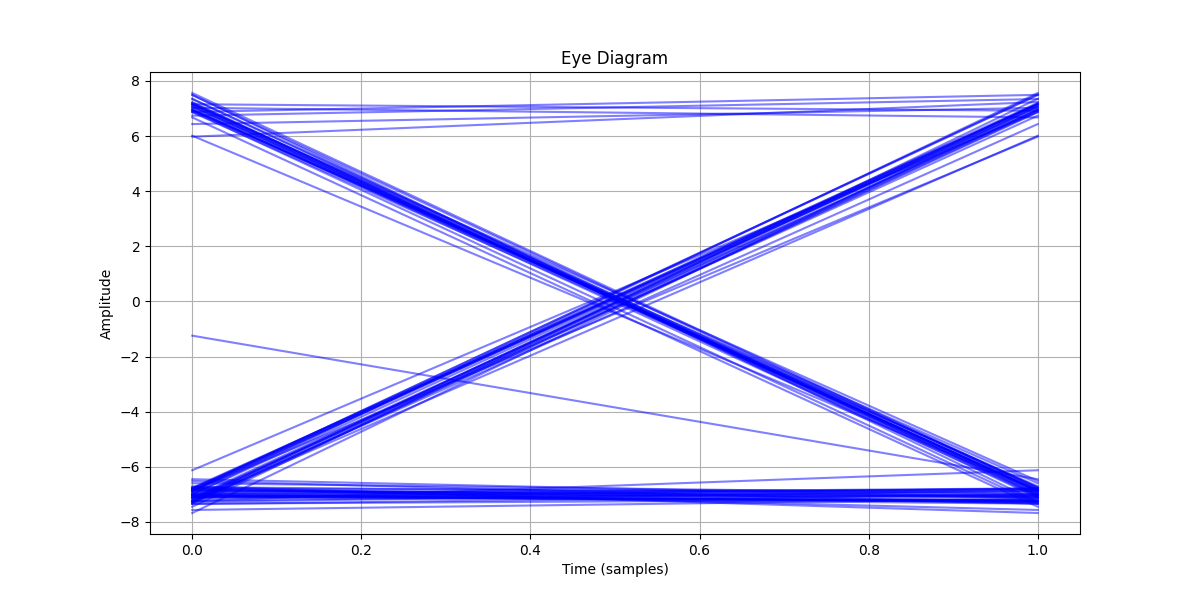

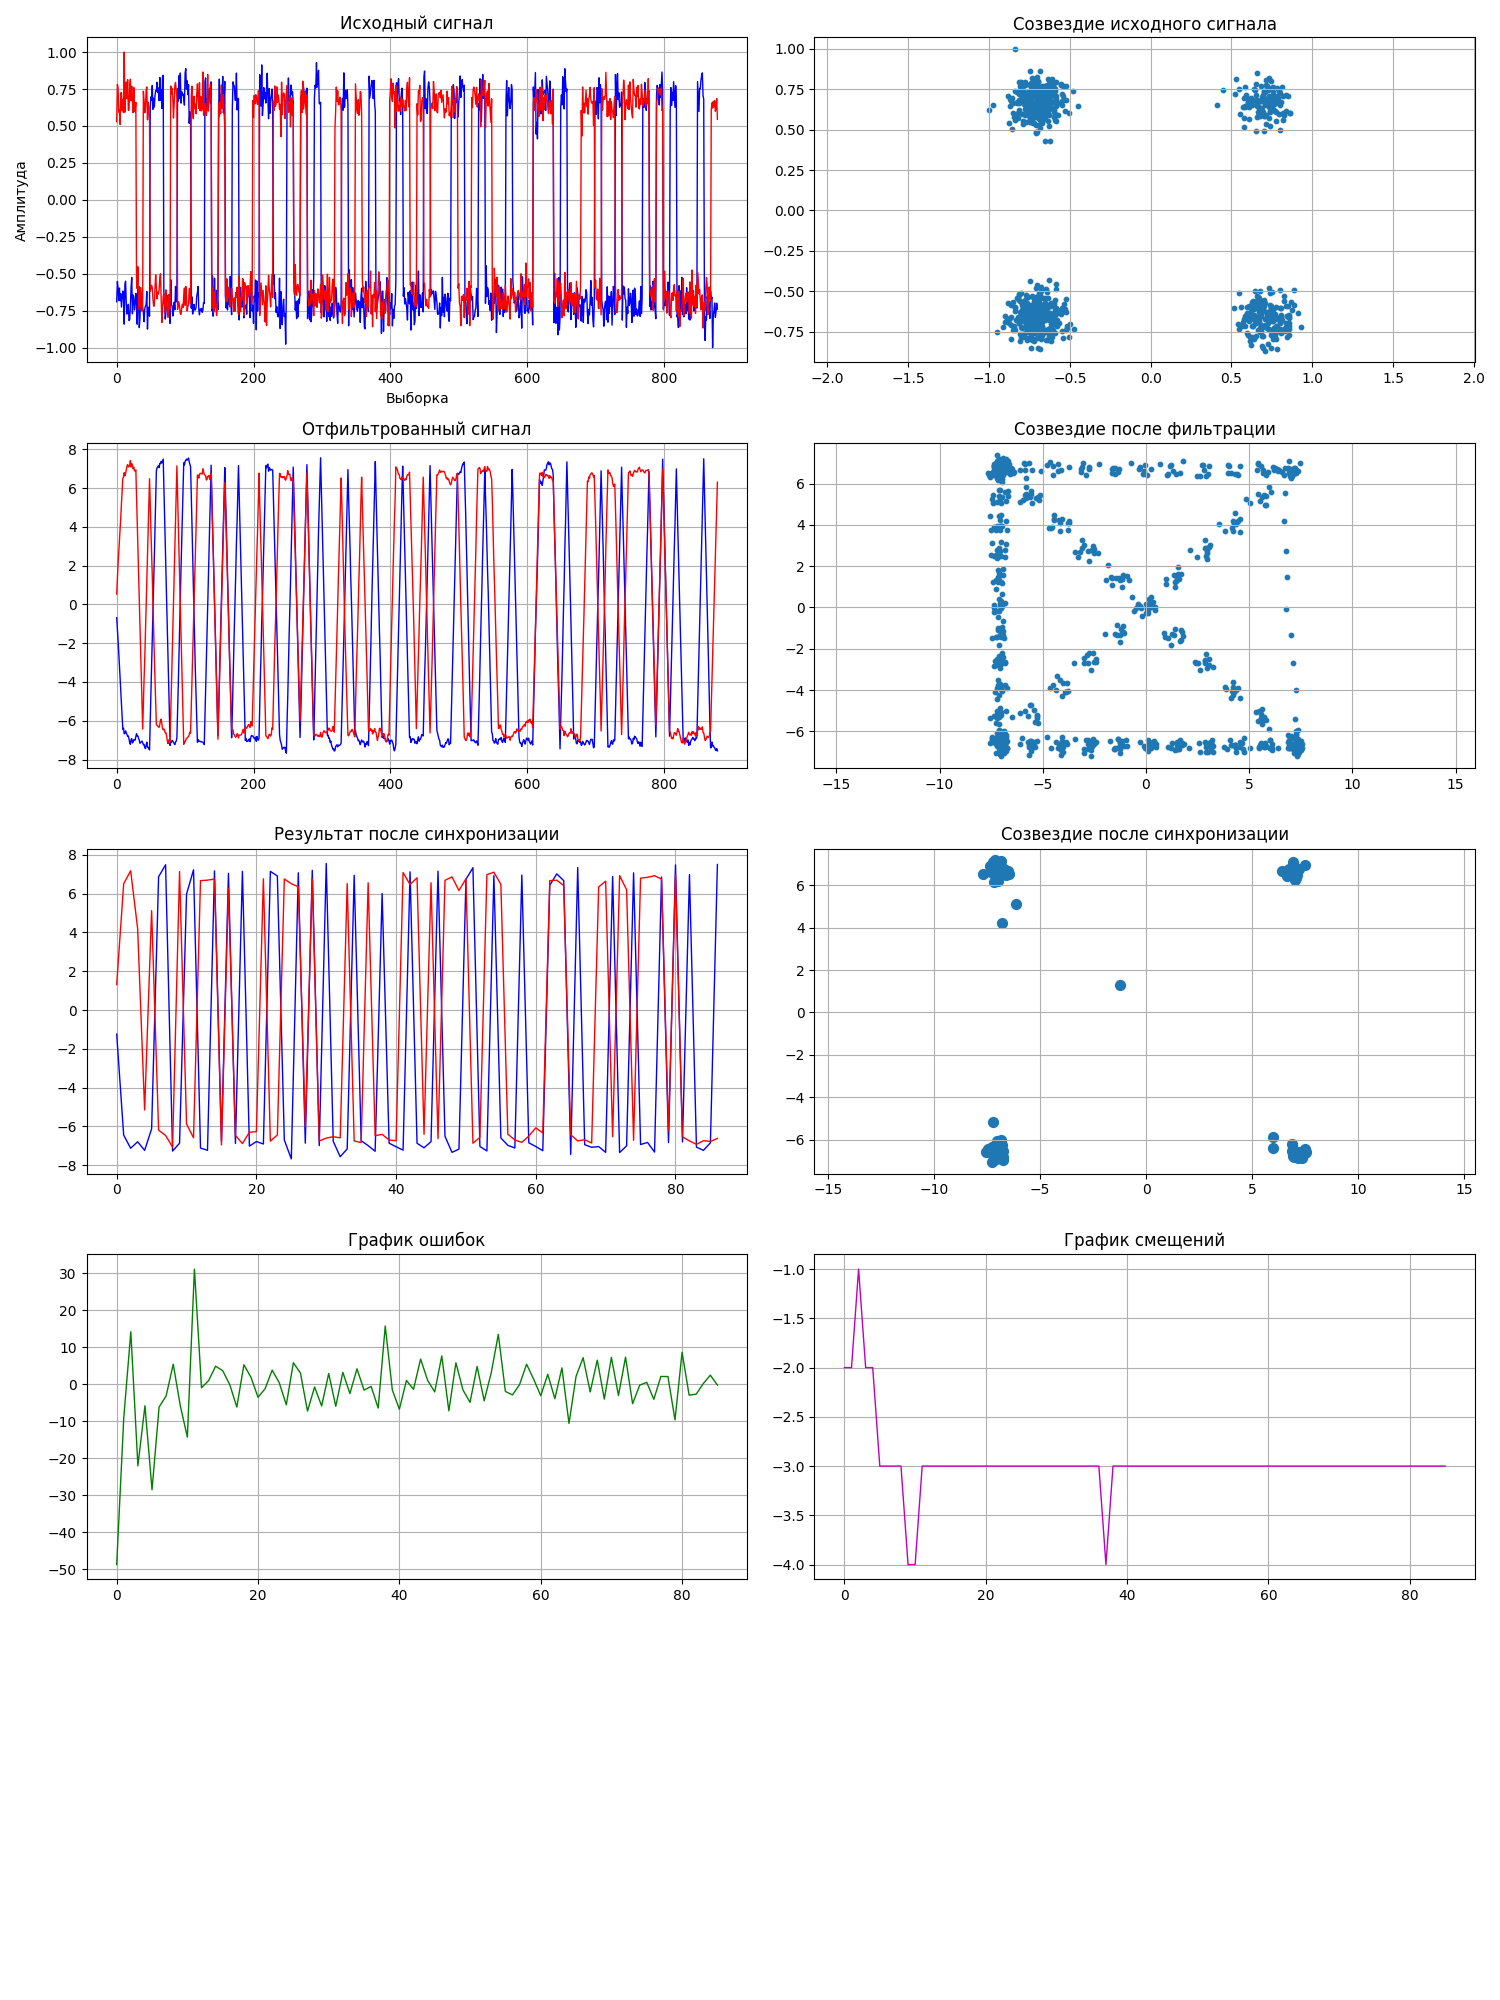

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os 
from scipy import signal

def plot_eye_diagram(signal, sps, num_traces=100):
    plt.figure(figsize=(12, 6))
    plt.title('Eye Diagram')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    for i in range(num_traces):
        start_idx = i * sps
        if start_idx + 2 * sps > len(signal):
            break
        plt.plot(range(2 * sps), signal[start_idx:start_idx + 2 * sps].real, color='blue', alpha=0.5)

def timing_recovery(IQ, alg, Nsps, n1st):
    N = len(IQ)
    I = np.real(IQ)
    Q = np.imag(IQ)

    damp = np.sqrt(2) / 2
    band = (0.5 * np.pi / 500) / (damp + 1/(4*damp))
    mi1 = (4 * damp * band) / ((1 + 2*damp*band + band**2) * 2.7)
    mi2 = (4 * band**2) / ((1 + 2*damp*band + band**2) * 2.7)
    
    err = []
    offset = []
    
    if Nsps > 2:
        k = 0
        ns = [n1st]
        offs = 0
        adap1 = 0
        adap2 = 0
        
        for n in range(n1st, len(IQ) - 2*Nsps, Nsps):
            if alg == 3:
                a = (I[n + Nsps + offs] - I[n + offs]) * I[n + Nsps//2 + offs]
                b = (Q[n + Nsps + offs] - Q[n + offs]) * Q[n + Nsps//2 + offs]
                current_err = -(a + b)
            elif alg == 4:
                current_err = -np.real(
                    (np.conj(IQ[n + Nsps + offs]) - np.conj(IQ[n + offs])) * IQ[n + Nsps//2 + offs]
                )
            elif alg == 5:
                a = I[n + offs] * np.sign(I[n + Nsps + offs]) - I[n + Nsps + offs] * np.sign(I[n + offs])
                b = Q[n + offs] * np.sign(Q[n + Nsps + offs]) - Q[n + Nsps + offs] * np.sign(Q[n + offs])
                current_err = -(a + b)
            
            adap2 += mi2 * current_err
            adap1 += adap2 + mi1 * current_err
            
            while adap1 > 1:
                adap1 -= 1
            while adap1 < -1:
                adap1 += 1
            
            offs = int(round(adap1 * Nsps))
            err.append(current_err)
            offset.append(offs)
            k += 1
            ns.append(n + Nsps + offs)
        
        IQs = IQ[ns]
        ns = np.array(ns)
    
    return ns, IQs, np.array(err), np.array(offset)

print(os.getcwd())
filename = './qpsk_signal_no_phase.bin'
# filename = '../../data/qpsk_signal_noise.bin'
data = np.fromfile(filename, dtype=np.int16).astype(np.float32)

start_sample = 441 * 2
end_sample = 1320 * 2

selected_data = data[start_sample:end_sample]

I = selected_data[::2]
Q = selected_data[1::2]

I /= np.max(np.abs(I) + 1e-6)
Q /= np.max(np.abs(Q) + 1e-6)

IQ = I + 1j*Q

# Применение фильтра
filter_length = 10
h = np.ones(filter_length)
I_filtered = signal.convolve(I, h, mode='full')[:len(I)]
Q_filtered = signal.convolve(Q, h, mode='full')[:len(Q)]
IQ_filtered = I_filtered + 1j*Q_filtered

alg = 3
Nsps = 10
n1st = 1

ns, IQs, err, offset = timing_recovery(IQ_filtered, alg, Nsps, n1st)

plt.figure(figsize=(15, 20))

plt.subplot(5, 2, 1)
plt.plot(np.real(IQ), 'b', linewidth=1)
plt.plot(np.imag(IQ), 'r', linewidth=1)
plt.title('Исходный сигнал')
plt.xlabel('Выборка')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(5, 2, 2)
plt.scatter(np.real(IQ), np.imag(IQ), s=10)
plt.title('Созвездие исходного сигнала')
plt.axis('equal')
plt.grid(True)

plt.subplot(5, 2, 3)
plt.plot(np.real(IQ_filtered), 'b', linewidth=1)
plt.plot(np.imag(IQ_filtered), 'r', linewidth=1)
plt.title('Отфильтрованный сигнал')
plt.grid(True)

plt.subplot(5, 2, 4)
plt.scatter(np.real(IQ_filtered), np.imag(IQ_filtered), s=10)
plt.title('Созвездие после фильтрации')
plt.axis('equal')
plt.grid(True)

if len(IQs) > 0 and len(ns) > 0:
    plt.subplot(5, 2, 5)
    plt.plot(np.real(IQs), 'b', linewidth=1)
    plt.plot(np.imag(IQs), 'r', linewidth=1)
    plt.title('Результат после синхронизации')
    plt.grid(True)
    
    plt.subplot(5, 2, 6)
    plt.scatter(np.real(IQs), np.imag(IQs), s=50)
    plt.title('Созвездие после синхронизации')
    plt.axis('equal')
    plt.grid(True)

plt.subplot(5, 2, 7)
if len(err) > 0:
    plt.plot(err, 'g', linewidth=1)
    plt.title('График ошибок')
    plt.grid(True)

plt.subplot(5, 2, 8)
if len(offset) > 0:
    plt.plot(offset, 'm', linewidth=1)
    plt.title('График смещений')
    plt.grid(True)

plt.tight_layout()

plot_eye_diagram(IQs,1,100)

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

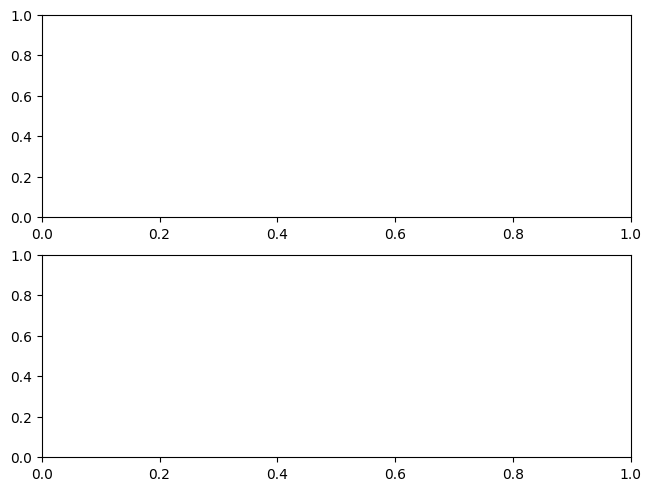

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Открываем файл для чтения
name = "/home/dmitry/sdrLessons/build/txdata.pcm"

data = []
imag = []
real = []
count = []
counter = 0
with open(name, "rb") as f:
    index = 0
    while (byte := f.read(2)):
        if(index %2 == 0):
            real.append(int.from_bytes(byte, byteorder='little', signed=True))
            counter += 1
            count.append(counter)
        else:
            imag.append(int.from_bytes(byte, byteorder='little', signed=True))
        index += 1
        
# Инициализируем список для хранения данных


fig, axs = plt.subplots(2, 1, layout='constrained')
axs[1].plot(count, np.abs(data),  color='grey')  # Используем scatter для диаграммы созвездия
#axs.plot(count,(imag),color='red')  # Используем scatter для диаграммы созвездия
#axs.plot(count,(real), color='blue')  # Используем scatter для диаграммы созвездия

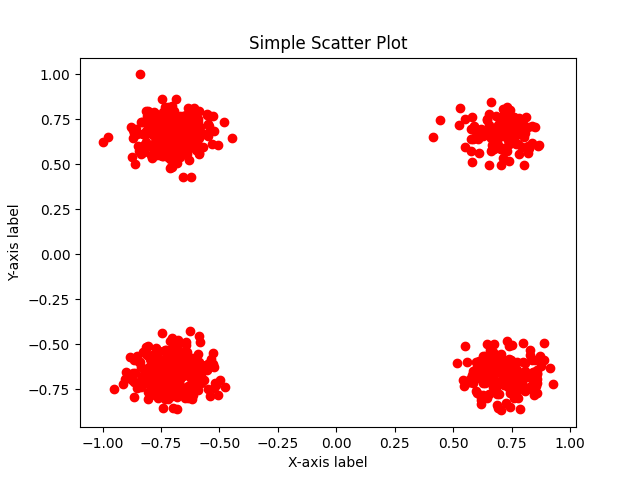

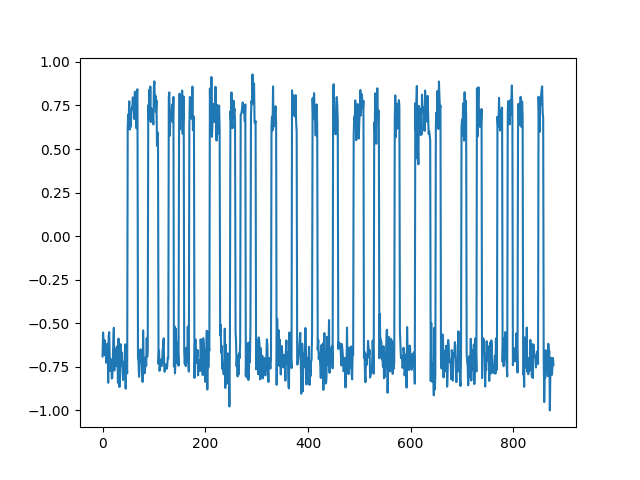

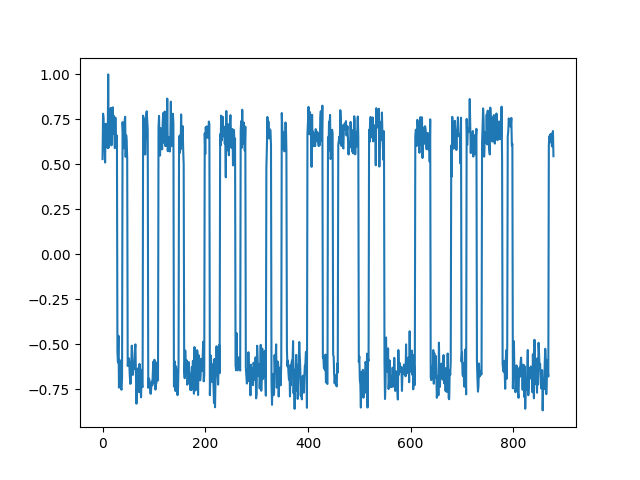

: 

In [ ]:
def i_q_visio(): 
    fig, ax = plt.subplots()

    ax.scatter(I, Q, label='Scatter plot', color='red')

    ax.set_xlabel('X-axis label')
    ax.set_ylabel('Y-axis label')
    ax.set_title('Simple Scatter Plot')

    fig1, ax = plt.subplots()

    #ax.plot(I, Q, label='Scatter plot', color='red')
    ax.plot(I)

    # ax.set_xlabel('X-axis label')
    # ax.set_ylabel('Y-axis label')
    # ax.set_title('Simple Scatter Plot')
    # ax.legend()

    fig2, ax2 = plt.subplots()

    #ax.plot(I, Q, label='Scatter plot', color='red')
    ax2.plot(Q)

    # ax2.set_xlabel('X-axis label')
    # ax2.set_ylabel('Y-axis label')
    # ax2.set_title('Simple Scatter Plot')
    # ax2.legend()
i_q_visio()



This is a display math example:
$$
\int_0^\infty e^{-x^2} dx = \frac{\sqrt{\pi}}{2}
$$

$$
T_{symb}
$$


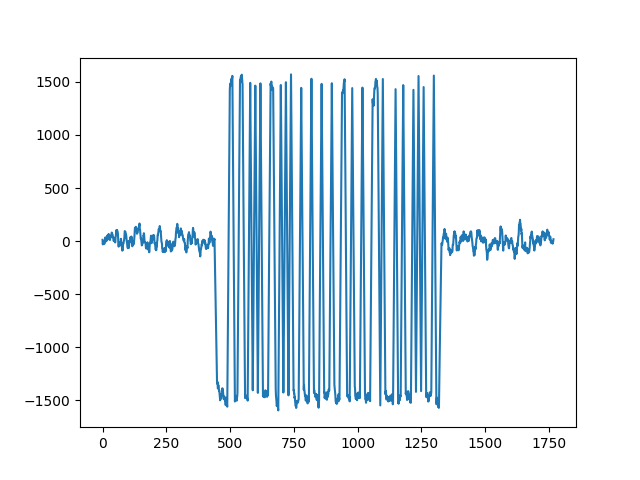

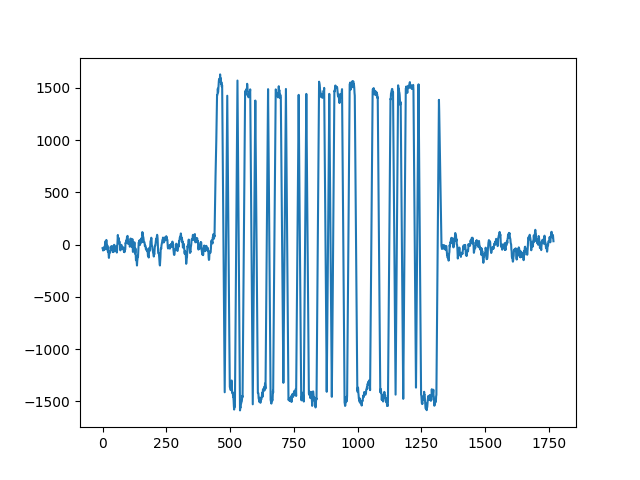

In [ ]:
tau_symb = 10   
def match_filter():   
    ones = np.ones(tau_symb) / tau_symb 

    I_convd = np.convolve(I, ones, mode="full") 
    Q_convd = np.convolve(Q, ones, mode="full") 
    
    fig_i, ax = plt.subplots() 

    ax.plot(I_convd) 

    fig_q, ax = plt.subplots() 

    ax.plot(Q_convd)
    
    return I_convd, Q_convd 

I, Q = match_filter()
    

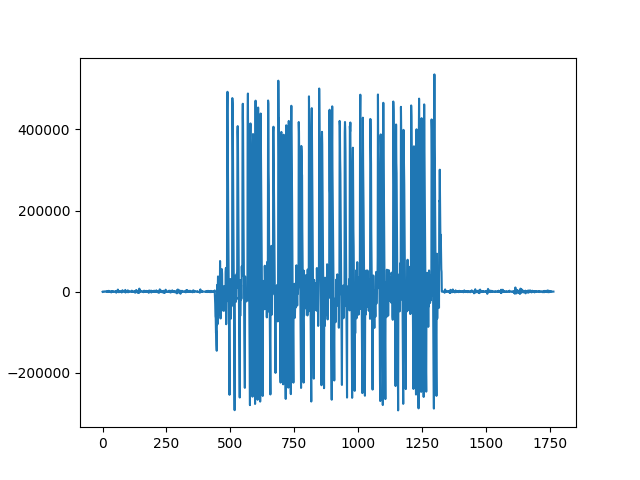

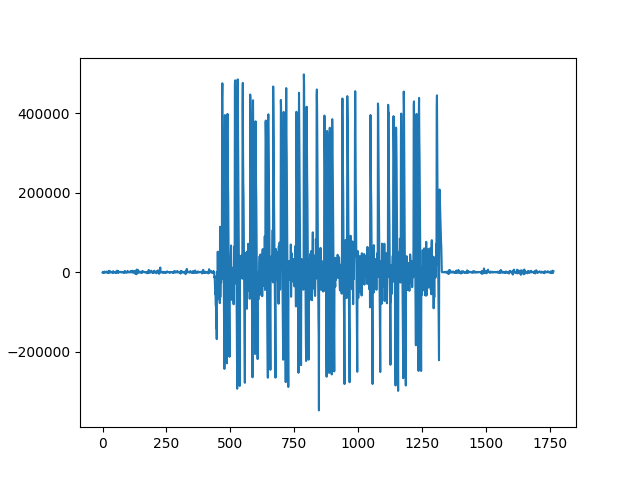

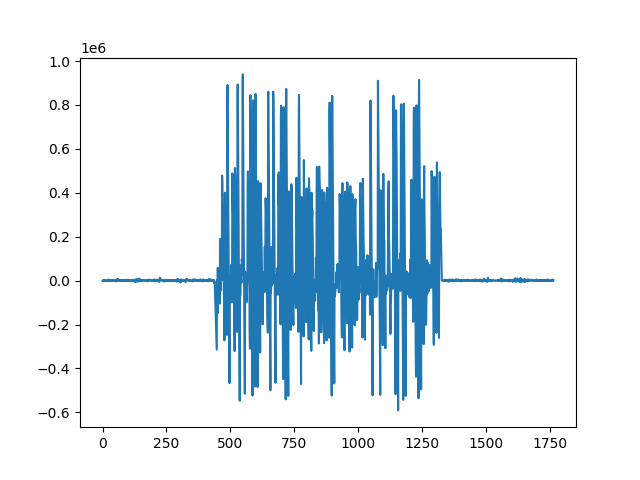

In [ ]:
def gardner_timing_error_qpsk(I, Q):
    errors_i = []
    errors_q = []
    for n in range(1, len(I) - 2):
        I_n, I_n_half, I_n_minus_T = I[n], I[n - 1], I[n + 1]
        Q_n, Q_n_half, Q_n_minus_T = Q[n], Q[n - 1], Q[n + 1]

        # Ошибка Гарднера
        error_I = I_n_half * (I_n - I_n_minus_T)
        error_Q = Q_n_half * (Q_n - Q_n_minus_T)
        errors_i.append(error_I) 
        errors_q.append(error_Q) 

    return np.array(errors_i), np.array(errors_q)

Ierr, Qerr = gardner_timing_error_qpsk(I, Q)

fig3, ax = plt.subplots()
ax.plot(Ierr)

fig3, ax = plt.subplots()
ax.plot(Qerr)

IQ_err = Ierr + Qerr 

fig4, ax = plt.subplots() 
ax.plot(IQ_err)

[s1,s2,s3,s4] * [0,1,0] 
  |  
[0, s2, 0]
    |
    [0, s3, 0]

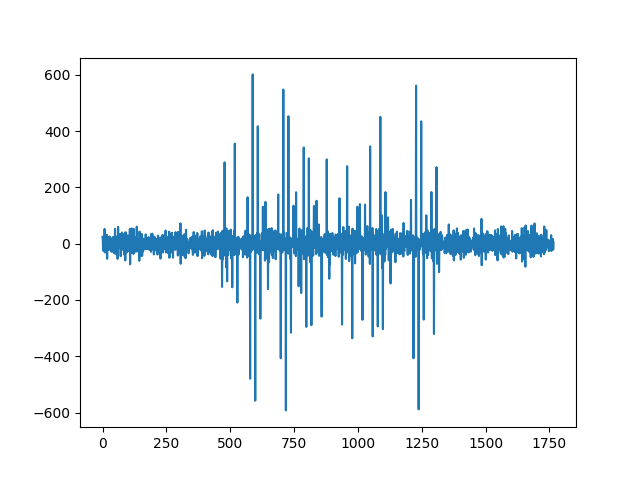

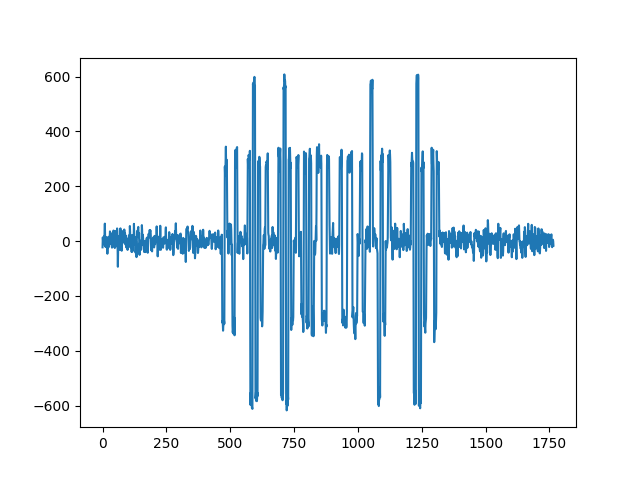

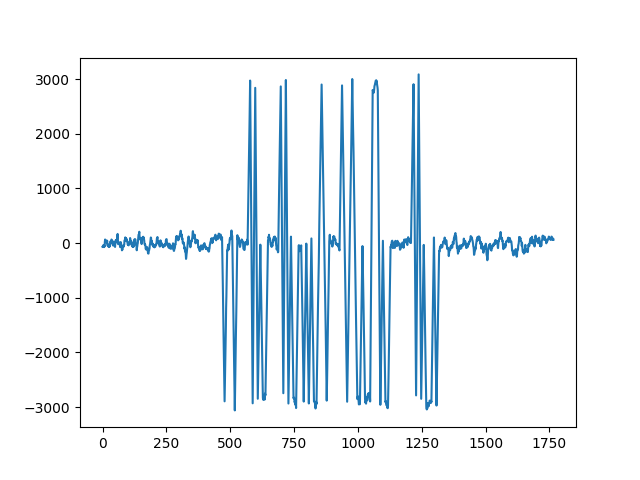

In [ ]:
x0 = np.convolve(I+Q, [0.5, -1, 0.5], mode="valid");  #

fig, ax = plt.subplots() 

ax.plot(x0) 

x1 = np.convolve(I+Q, [0.5, 0, -0.5], mode="valid") 

fig, ax = plt.subplots() 

ax.plot(x1) 

x3 = np.convolve(I+Q, [0,1,0], mode="valid") 

fig, ax = plt.subplots() 

ax.plot(x3) 


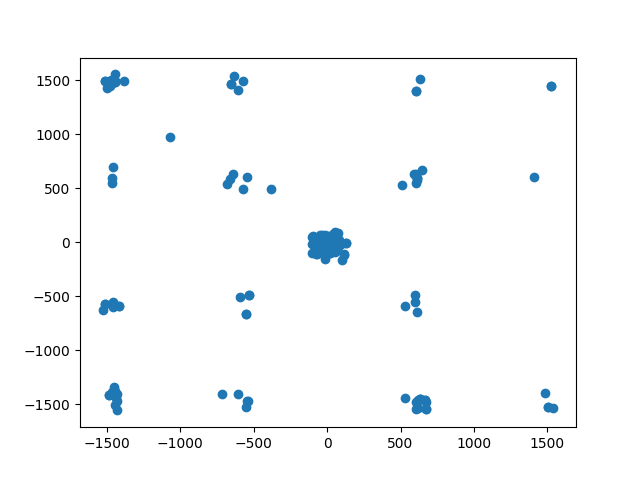

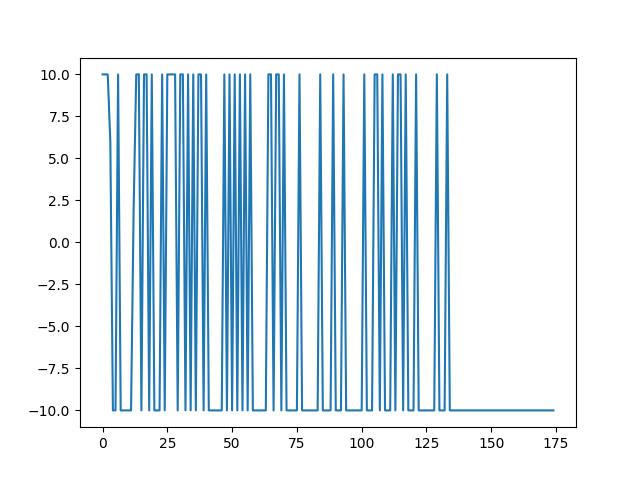

In [ ]:
def timing_sync(Nsps=10, N1st=2):
    damp = np.sqrt(2) / 2   

    # Полоса?? ЧЕГО БЛЯТЬ ЗА ПОЛОСА НАХУЙ
    damping_factor = 2.7
    band = (0.5 * np.pi / 500) / (damp + 1 / (4 * damp)) 
    mi1 = (4 * damp * band) / ((1 + 2 * damp * band + band ** 2) * damping_factor)
    mi2 = (4 * band ** 2 ) / ((1 + 2 * damp * band + band ** 2) * damping_factor)

    if (Nsps > 2): 
        # TODO docs
        ns, err, offset = [N1st], [], []
        # TODO docs
        offs, adapt1, adapt2 = 0,0,0 
        # TODO docs 
        
        Is = [] 
        Qs = []

        for n in range(N1st, len(I) -  2 * Nsps, Nsps): 
            #gardner
            err_I = (I[n + Nsps + offs] - I[n + offs]) * I[n + Nsps // 2 + offs]
            err_Q = (Q[n + Nsps + offs] - Q[n + offs]) * Q[n + Nsps // 2 + offs]

            cur_err = -(err_I + err_Q) 

            adapt2 += mi2 * cur_err
            adapt1 += adapt2 + mi1 * cur_err

            # нормализация
            adapt1 = np.clip(adapt1, -1, 1) 

            offs = round(adapt1 * Nsps)     
            offset.append(offs) 
            err.append(cur_err) 
            ns.append(n + Nsps + offs) 
        
        Is = I[ns] 
        Qs = Q[ns] 

    return np.array(ns), np.array(Is), np.array(Qs), np.array(err), np.array(offset)


ns, Is, Qs, err, offset = timing_sync() 

fig, ax = plt.subplots() 

ax.scatter(Is, Qs)

fig, ax = plt.subplots() 

ax.plot(offset) 
# def qpsk_sync():
#     tau = 1.0 
#     step = 0.01
#     I_sync, Q_sync = [], [] 

#     for n in range(1, len(I) - 2): 
#         tau += step * IQ_err[n] 

#         idx = abs(int(round(tau))) 

#         if idx < len(IQ_err): 
#             I_sync.append(I[idx]) 
#             Q_sync.append(Q[idx]) 

#     return I_sync, Q_sync

# I_synced, Q_synced = qpsk_sync()

# fig, ax = plt.subplots() 

# ax.scatter(I_synced, Q_synced)

In [ ]:
def qpsk_modulate(v_bits): 
    S = np.array(); 
    for i in range(len(v_bits)):
        bit = v_bits[i] 

        if (bit == 0): 
            bit = -1
        else: 
            bit = 1 

        if (is_even(i)): # I 
            S.append(bit * np.cos() )
        #if (is_odd(i)):  # Q 
